In [1]:
%matplotlib inline


Extracting signals from a brain parcellation
============================================

Here we show how to extract signals from a brain parcellation and compute
a correlation matrix.

We also show the importance of defining good confounds signals: the
first correlation matrix is computed after regressing out simple
confounds signals: movement regressors, white matter and CSF signals, ...
The second one is without any confounds: all regions are connected to
each other.


One reference that discusses the importance of confounds is `Varoquaux and
Craddock, Learning and comparing functional connectomes across subjects,
NeuroImage 2013
<http://www.sciencedirect.com/science/article/pii/S1053811913003340>`_.

This is just a code example, see the `corresponding section in the
documentation <parcellation_time_series>` for more.

<div class="alert alert-info"><h4>Note</h4><p>This example needs SciPy >= 1.0.0 for the reordering of the matrix.</p></div>



Retrieve the atlas and the data
--------------------------------



In [2]:
from nilearn import datasets
parcellations = datasets.fetch_atlas_basc_multiscale_2015()

In [3]:
from nilearn import datasets

#dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
#atlas_filename = dataset.maps
#labels = dataset.labels
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

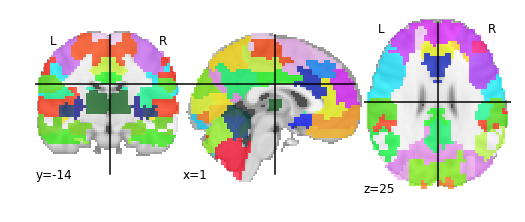

In [4]:
import matplotlib.pyplot as plt
from nilearn import plotting

plotting.plot_roi(atlas_filename)


Great, let's load an example 4D fmri time-series for one subject

In [5]:
# One subject of resting-state data
data = datasets.fetch_adhd(n_subjects=1)
fmri_filenames = data.func[0]
print('fmri timeseries are located in nifti image (4D) at: %s' %
       fmri_filenames)  # 4D data

fmri timeseries are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/datasets/func.py:502: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


And let's have a look at that

In [6]:
plotting.plot_epi(fmri_filenames)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

Uh oh! An error! What's the problem here?

In [7]:
from nilearn.image import load_img
from nibabel import Nifti1Image
myImg = load_img(fmri_filenames)
myImg_data = myImg.get_data()
myImg_aff = myImg.affine

averaged_data = myImg_data.mean(axis=3)
averaged_Img = Nifti1Image(averaged_data, myImg_aff)

Let's try that again

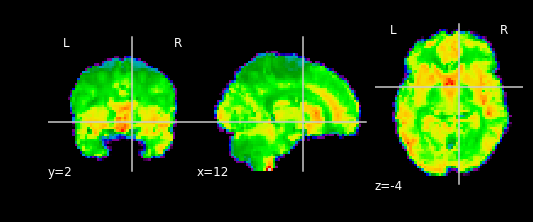

In [9]:
plotting.plot_epi(averaged_Img)

Extract signals on a parcellation defined by labels
-----------------------------------------------------
Using the NiftiLabelsMasker



In [8]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           resampling_target='labels',
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
time_series = masker.fit_transform(myImg, confounds=data.confounds)

[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[Memory]    0.4s, 0.0min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


In [9]:
type(time_series)

numpy.ndarray

In [10]:
time_series.shape

(176, 64)

Compute and display a correlation matrix
-----------------------------------------



In [13]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

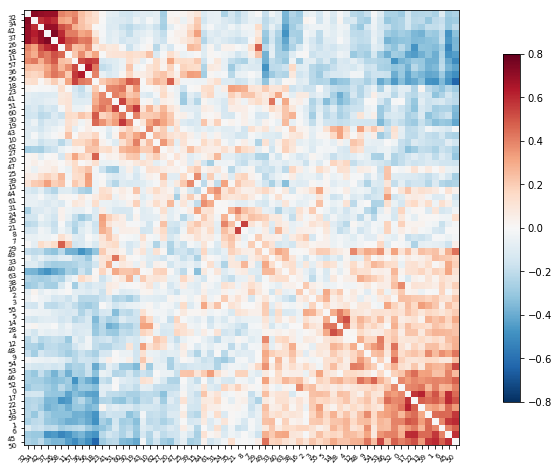

In [12]:
# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The labels we have start with the background (0), hence we skip the
# first label
# matrices are ordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=True)

Same thing without confounds, to stress the importance of confounds
--------------------------------------------------------------------



[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
[Memory]  147.4s, 2.5min: Loading filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


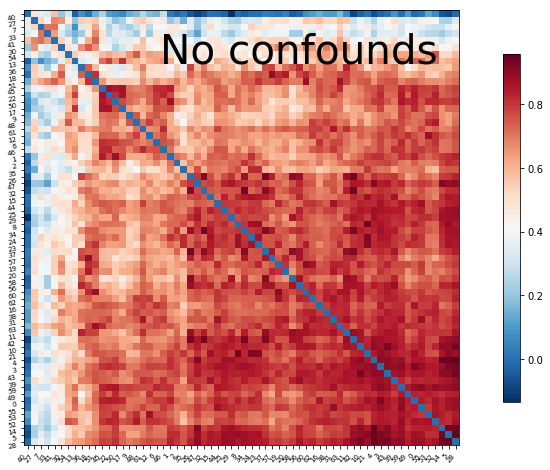

In [17]:
time_series = masker.fit_transform(fmri_filenames)
# Note how we did not specify confounds above. This is bad!

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=range(time_series.shape[-1]),
                    title='No confounds', reorder=True)

plotting.show()